[Timer] Pricing exécuté en 0.0429 secondes.
Prix de l’option: 15.387112669995128
Black-Scholes Price: 15.1503


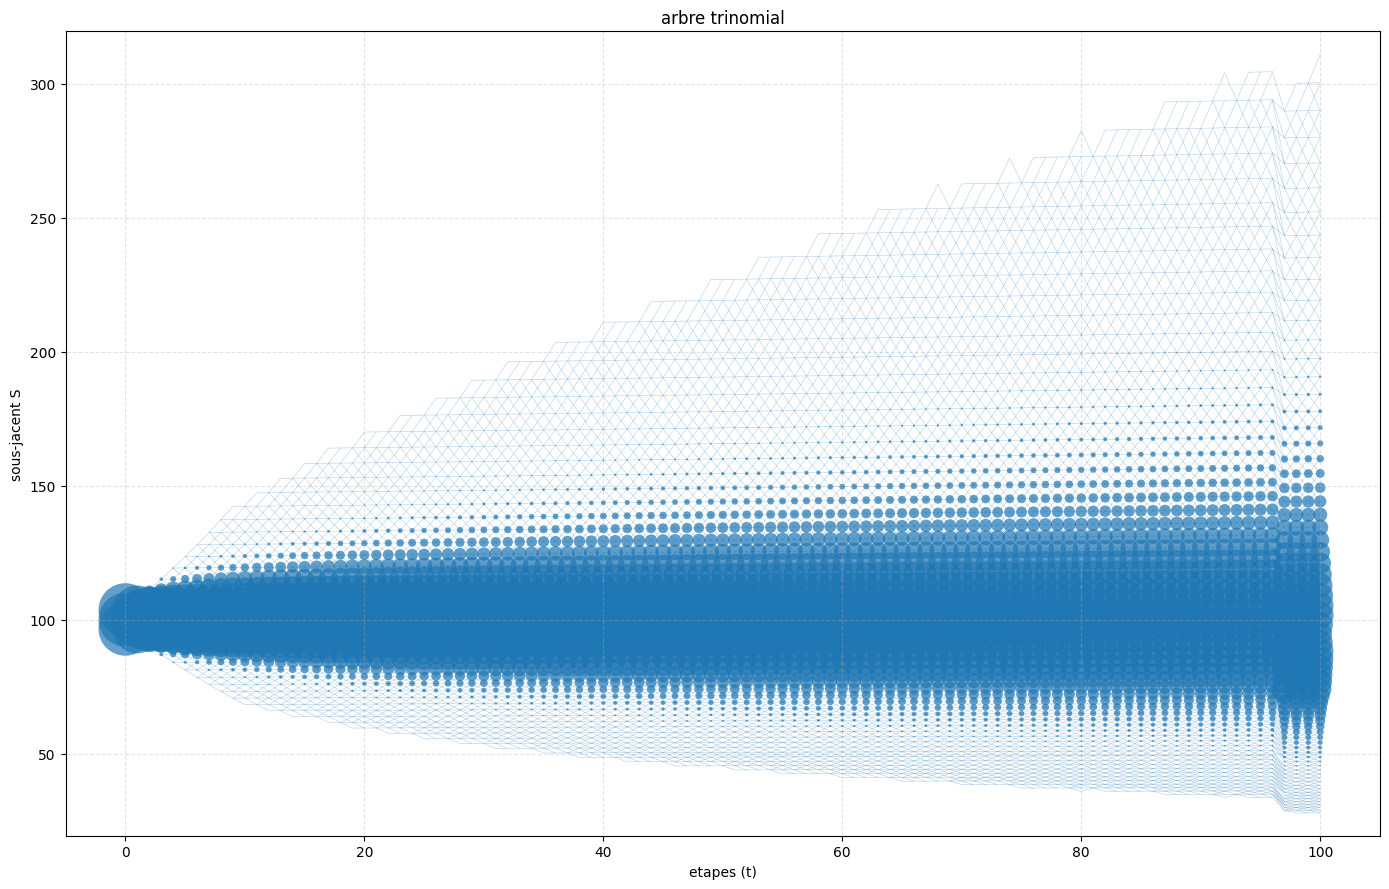

In [6]:
from pricing import BlackScholesPricer, TrinomialTree, Market, Option
from pricing.convergence import *
import datetime as dt
import sys
# limite de récursion modifée
sys.setrecursionlimit(100000)

# parametrage de l'arbre
market = Market(S0=100, r=0.03, sigma=0.2, dividend=5, dividend_date=dt.datetime(2026, 10, 20))
option = Option(K=110, option_type="put", maturity=dt.datetime(2026, 10, 30), option_class="american")
tree = TrinomialTree(market, N=100, pruning=True, epsilon=1e-7)

# prix de l'arbre
price = tree.price(option, compute_greeks=True, activate_timer=True)
print("Prix de l’option:", price)

# black Scholes
bs = BlackScholesPricer(S=market.S0, K=option.K, T=tree.delta_t*tree.N, r=market.r, sigma=market.sigma, option_type='put', dividend=market.dividend, dividend_date = market.dividend_date)
bs_price = bs.price()
print("Black-Scholes Price: {:.4f}".format(bs_price))

# graphique de l'arbre
tree.plot_tree(tree.N)

# Graphique de Convergence et d'Erreur

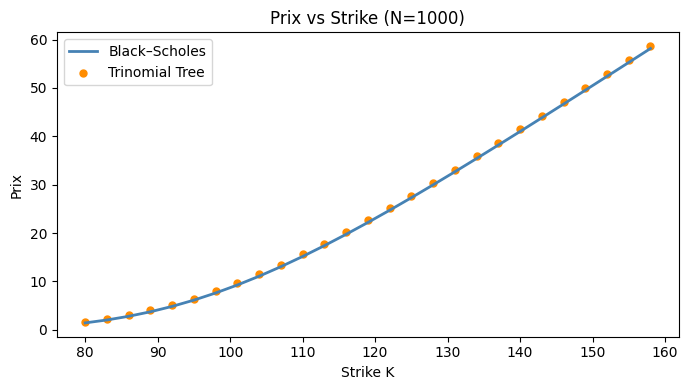

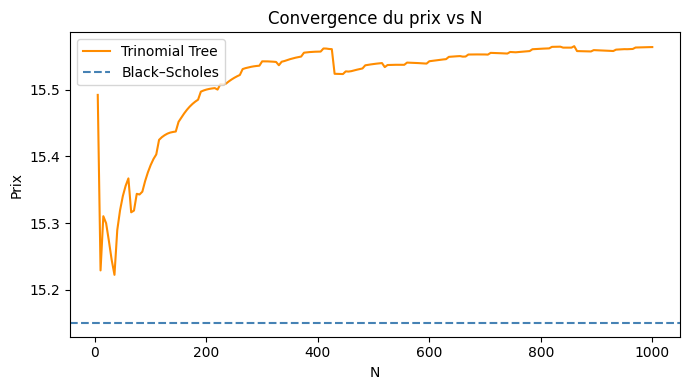

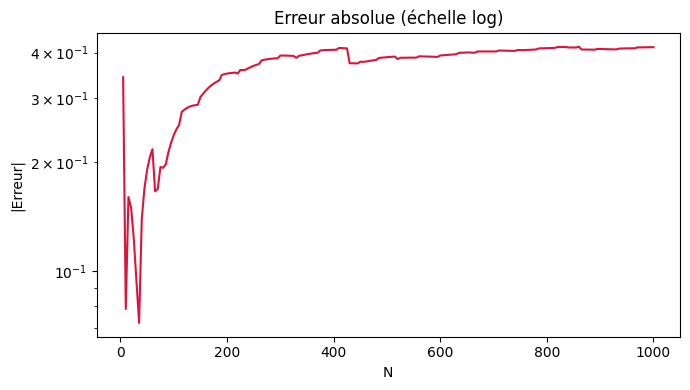

In [5]:
bs_convergence_by_strike(market, option, strikes=range(80, 161, 3), n_steps=1000)
bs_convergence_by_step(market, option, max_n=1000, step=5)

# Grecques - Arbre Trinomial

In [2]:
print(f"Delta : {tree.delta():.6f}")
print(f"Gamma : {tree.gamma():.6f}")
print(f"Vega  : {tree.vega(option):.6f}")   # déjà par 1% de vol
print(f"Vanna : {tree.vanna(option):.6f}")  # déjà par 1% de vol
print(f"Rho   : {tree.rho(option):.6f}")    # déjà par 1% de taux

Delta : 0.413475
Gamma : 0.019261
Vega  : 0.394372
Vanna : 0.008763
Rho   : 0.369229


# Grecques - Black-Scholes

In [3]:
bs.greeks()

{'delta': 0.4134466041141795,
 'gamma': 0.019265804746051423,
 'theta': -0.013510812713292021,
 'vega': 0.3937613791932702,
 'rho': 0.36730645004174056,
 'vanna': 0.00819673312412271}

In [ ]:
# soutenance sur teams de 30 min
# 2 quizz jusqu'à 17h le 29/10 : un qualitatif -> questions et un quantitatif où on va 
# devoir utiliser notre code pour répondre (possible de faire un ajout de code aussi)
# exemple qualitatif : quelle est le plus gros reproche de l'abre trinomial
# le qualitatif c'est 20 questions en 20 minutes sans retour parfois choix multiples (plus qu'une réponse 
# à chaque questions à choix multiples)
# les calculs sont que des calculs faisables de test
# le qcm quantitatif n'est pas limité dans le temps (pricing d'options, du delta hedge, calcul de vega)
# toujours saisi sans retour

delta: prix_option en S0+epsilon (dans le temps) + prix_option en S0-epsilon/ 2*epsilon
c'est au QCM ça.
Les risk managers font des delta en pourcentage de la valeur du produit pour avoir des calls en % pour pouvoir comparer des produits similaires. Le epsilon est par exemple 1% de la valeur du produit. epsilon = 0.4 pour un produit à 40 et 4 pour un produit à 400 (décalage d'1%)
Il faudra utiliser la première méthode pour le QCM.

Gamma: dérivé du delta donc --> delta+ - delta- si unité de 1 de décalage
Avec un epsilon : (delta+(de epsilon) - delta-)/epsilon
à partir du prix = (Prixoption(S0 + epsilon) + Prixoption(S0-epsilon) - 2*Prixoption(S0)) / epsilon^2

Vega : (dérivé du prix par sigma) * 1%
 = (PrixS0 + 1% - PrixS0 - 1%)/2 car c'est de la vol

vega = dérivé seconde par rapport à la vol

vanna = dérivé croisée = dérivé du vega par rapport au spot = dérivée du delta par rapport à la vol


dérivée dans le code:
le callable est une fonction qui doit prendre un float en argument (valeur par rapport à laquelle on dérive)
shift = amplituyde de la variation

In [ ]:
# partir de la fin de l'arbre et casser les liens en les mettant = None
# , pas oublier de casser les liens du noeud vers l'arbre
# ça c'est pour VBA (avec compteur du nombre de noeud).
# pour python pareil